# Bumble Dating App - Google Play Store Review

This dataset belongs to the Bumble app available on the Google Play Store. It contains user reviews and scores given to the platform.

In [1]:
# Imports
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [2]:
# Custom functions
os.chdir("..")
import utils.text_utils as tu

### Table head

In [3]:
# Load data
data = pd.read_csv("./data/raw/bumble_google_play_reviews.csv")
data.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOGCWX1s8NNKNYQ5uMKTqiOTl1wci0EXqB1YMF4...,Javed Sahiad,https://play-lh.googleusercontent.com/a-/AOh14...,Bumble rocks 👍🤞,5,0,5.253.0,2022-03-28 23:33:04,NaN,NaN
1,gp:AOqpTOFmBlHJLKFu87RU2d-AKSXiIzUd_utDNWBKhsw...,Justin Miller,https://play-lh.googleusercontent.com/a-/AOh14...,Just a cash grab. Congrats you have 2 new like...,1,0,5.262.0,2022-03-28 23:23:30,NaN,NaN
2,gp:AOqpTOHAcFeMyfgGN_6k7HRCTRwYS2q1mKCA_t5YIkf...,Adam Poots,https://play-lh.googleusercontent.com/a/AATXAJ...,"Terrible, l have lost total faith in this app,...",1,15,5.260.0,2022-03-28 23:10:12,Uh oh! We'll need some more account informatio...,2022-02-23 12:33:01


## Raw data

In [4]:
# Format columns
data['at'] = pd.to_datetime(data['at'] )
data['score'] = pd.to_numeric(data['score'] )

### Data description

In [5]:
unique_users = len(data['userName'].unique())
start_date = data['at'].min()
end_date = data['at'].max()
avg_rating = data['score'].mean()

print(f"Total comments: {data.shape[0]:d}")
print(f"Unique users: {unique_users:d}")
print(f"Period of analysis: {start_date} to {end_date}")
print(f"Average rating: {avg_rating:2f}")

Total comments: 105438
Unique users: 95286
Period of analysis: 2015-11-29 23:15:25 to 2022-03-28 23:33:04
Average rating: 2.829284


There are little to none missing values in the data, especially in the columns of interest (at, content, score).
Rows with missing **content** will be dropped.

In [9]:
data.isna().sum()/data.shape[0]*100

reviewId                 0.000000
userName                 0.000000
userImage                0.000000
content                  0.003794
score                    0.000000
thumbsUpCount            0.000000
reviewCreatedVersion    15.906030
at                       0.000000
replyContent            41.917525
repliedAt               41.917525
dtype: float64

### Volume of comments by month

We will start the analysis from 2015-12-31 since there are only 2 observations for 2015-11-30.

In [22]:
nComment_trend = data.groupby(by=pd.Grouper(key="at", freq="M"))['content'].count()
nComment_trend

at
2015-11-30       1
2015-12-31     168
2016-01-31     276
2016-02-29     313
2016-03-31     359
              ... 
2021-11-30    1969
2021-12-31    2910
2022-01-31    3233
2022-02-28    2812
2022-03-31    2689
Freq: M, Name: content, Length: 77, dtype: int64

<AxesSubplot:title={'center':'# Comments'}, xlabel='at'>

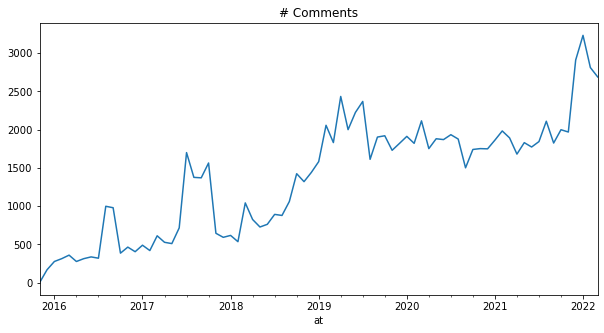

In [16]:
plt.figure(figsize=(10,5))
plt.title("# Comments")
nComment_trend.plot()

## Preprocessed data

- Filter by date
- Select relevant columns
- Drop rows with missing values
- Format numeric and date columns
- Clean textual data:
    - To lower
    - Remove stopwords, numbers and punctuation
    - Lemmatize

In [30]:
# Filter by date
data = data[data['at']>'2015-12-01']

In [36]:
# Select columns
columns = ['at', 'score', 'content']
clean_data = data.loc[~data.content.isna(),columns].copy()
print("Selected columns:", columns)
print("Rows dropped:", len(data)-len(clean_data))

Selected columns: ['at', 'score', 'content']
Rows dropped: 5


In [4]:
# Clean text
clean_data['clean_content'] = list(map(lambda x: tu.clean_text(str(x), lemmatize=True), clean_data['content']))

# Drop data with missing content after cleaning
clean_data.dropna(inplace=True)

In [20]:
# Compute sentiment (Sentiment Analysis MVP)
opinion_dict = pd.read_csv("./data/preprocessed/opinion_dict.csv")
clean_data['sentiment'] = list(map(lambda x: tu.get_sentiment(x, opinion_dict), clean_data['clean_content']))

In [8]:
#clean_data.to_csv("./data/preprocessed/bumble_preprocessed.csv", index = False)
clean_data.head()

,at,score,content,clean_content,sentiment
0,2022-03-28 23:33:04,5,Bumble rocks 👍🤞,bumble rock,0.000
1,2022-03-28 23:23:30,1,Just a cash grab. Congrats you have 2 new like...,cash grab congrats new like let swipe right fi...,0.071
2,2022-03-28 23:10:12,1,"Terrible, l have lost total faith in this app,...",terrible lost total faith app promised contact...,-0.118
3,2022-03-28 22:28:33,5,Easy to use,easy use,0.500
4,2022-03-28 22:20:53,1,"Just alot of gimmicks, fake profile, and upsal...",alot gimmick fake profile upsales decide delet...,-0.167


### Top words

In [38]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(clean_data['clean_content'].values)

In [25]:
word_counts = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'count': X.toarray().sum(axis=0)})
word_counts.sort_values(by='count', ascending=False, inplace=True, ignore_index=True)

word_counts.head(10)

,word,count
0,app,48225
1,match,17842
2,like,16684
3,people,14502
4,get,13403
5,good,13276
6,time,11438
7,bumble,10776
8,profile,10130
9,woman,9717
